# Twitter Bot Accounts

[Twitter Bot Accounts](https://www.kaggle.com/davidmartngutirrez/twitter-bots-accounts?select=twitter_human_bots_dataset.csv)


`friends_count` = Following

`followers_count` = Followers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
raw_df = pd.read_csv('data_files/twitter_human_bots_dataset.csv.zip', index_col=False)

In [3]:
raw_df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
raw_df.head(3)

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human


In [5]:
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].apply(lambda x: 1 if x == True else 0)
raw_df['default_profile_image'] = raw_df['default_profile_image'].apply(lambda x: 1 if x == True else 0)
raw_df['geo_enabled'] = raw_df['geo_enabled'].apply(lambda x: 1 if x == True else 0)
raw_df['verified'] = raw_df['verified'].apply(lambda x: 1 if x == True else 0)


In [6]:
df = raw_df[['bot', 'screen_name', 'created_at', 'verified', 'location', 'geo_enabled', 'lang', 'default_profile', 
              'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count',
             'average_tweets_per_day', 'account_age_days', 'description']]

In [7]:
del raw_df

In [8]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [9]:
df['friends_log'] = np.round(np.log(1+ df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1+ df['followers_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

df['popularity'] = np.round(np.log(1 + df['friends_count']) * np.log(1 + df['followers_count']), 3)

In [10]:
df.head(3)

,bot,screen_name,created_at,verified,location,geo_enabled,lang,default_profile,default_profile_image,favourites_count,followers_count,friends_count,statuses_count,average_tweets_per_day,account_age_days,description,friends_log,followers_log,avg_daily_tweets_log,popularity
0,1,best_in_dumbest,2016-10-15 21:32:11,0,unknown,0,en,0,0,4,1589,4,11041,7.870,1403,"Blame @xaiax, Inspired by @MakingInvisible, us...",1.609,7.371,2.183,11.864
1,0,CJRubinPhoto,2016-11-09 05:01:30,0,Estados Unidos,0,en,0,0,536,860,880,252,0.183,1379,Photographing the American West since 1980. I ...,6.781,6.758,0.168,45.827
2,0,SVGEGENT,2017-06-17 05:34:27,0,"Los Angeles, CA",1,en,0,0,3307,172,594,1001,0.864,1159,Scruffy looking nerf herder and @twitch broadc...,6.389,5.153,0.623,32.922


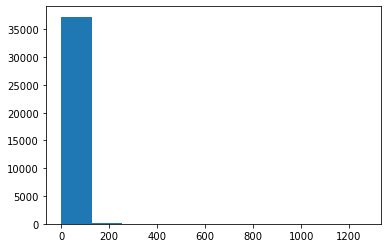

In [11]:
# average tweets per day -- OH
plt.hist(df.average_tweets_per_day);

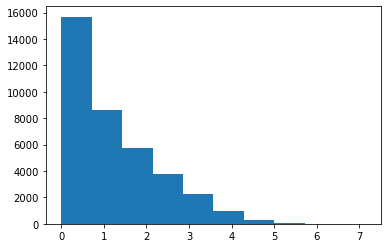

In [12]:
plt.hist(df.avg_daily_tweets_log);

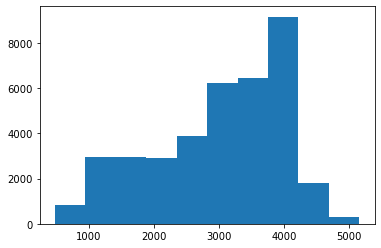

In [13]:
# Account age
plt.hist(df.account_age_days);

In [15]:
bots = df[df['bot'] == 1]
humans = df[df['bot'] == 0]

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


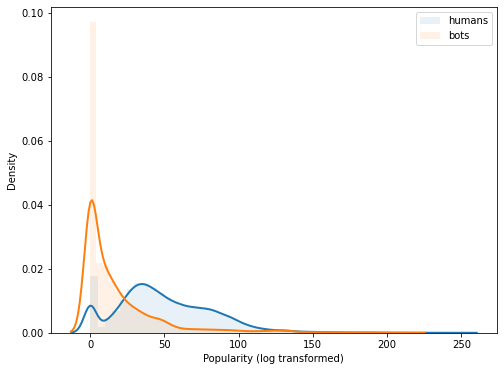

In [16]:
plt.figure(figsize=(8,6))
sns.distplot(x=humans.popularity, hist_kws=dict(alpha=.1), kde_kws={'linewidth': 2}, label='humans');
sns.distplot(x=bots.popularity, hist_kws=dict(alpha=.1), kde_kws={'linewidth': 2}, label='bots')
plt.ylabel('Density')
plt.xlabel('Popularity (log transformed)')
plt.legend(loc='best');

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


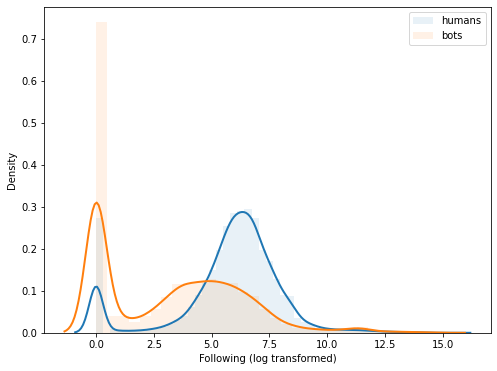

In [17]:
plt.figure(figsize=(8,6))
sns.distplot(x=humans.friends_log, hist_kws=dict(alpha=.1), kde_kws={'linewidth': 2}, label='humans');
sns.distplot(x=bots.friends_log, hist_kws=dict(alpha=.1), kde_kws={'linewidth': 2}, label='bots')
plt.ylabel('Density')
plt.xlabel('Following (log transformed)')
plt.legend(loc='best');

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


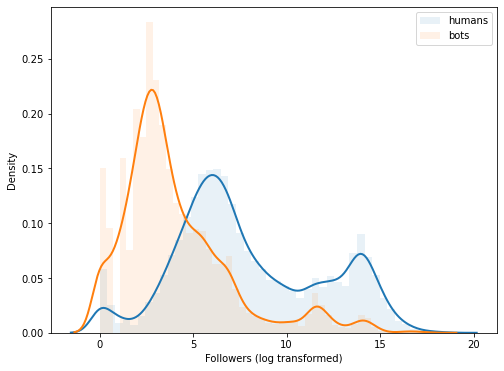

In [18]:
plt.figure(figsize=(8,6))
sns.distplot(x=humans.followers_log, hist_kws=dict(alpha=.1), kde_kws={'linewidth': 2}, label='humans');
sns.distplot(x=bots.followers_log, hist_kws=dict(alpha=.1), kde_kws={'linewidth': 2}, label='bots')
plt.ylabel('Density')
plt.xlabel('Followers (log transformed)')
plt.legend(loc='best');

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


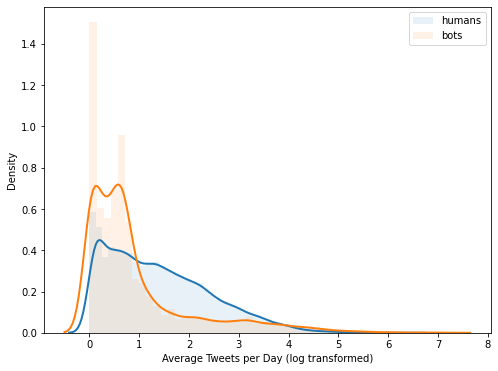

In [19]:
plt.figure(figsize=(8,6))
sns.distplot(x=humans.avg_daily_tweets_log, hist_kws=dict(alpha=.1), kde_kws={'linewidth': 2}, label='humans');
sns.distplot(x=bots.avg_daily_tweets_log, hist_kws=dict(alpha=.1), kde_kws={'linewidth': 2}, label='bots')
plt.ylabel('Density')
plt.xlabel('Average Tweets per Day (log transformed)')
plt.legend(loc='best');